In [27]:
import pandas as pd
import numpy as np
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib.ticker import PercentFormatter

import ipywidgets as widgets
from ipywidgets import interact
from tqdm import tqdm

In [2]:
from PerfStats import summary_stats

In [3]:
with open("output/ShrinkageRS/ShrinkageRS_mvo_dict_jpy.pickle", "rb") as f:
    ShrinkageRS_dict = pickle.load(f)
eret_dict = ShrinkageRS_dict["eret"]
cov_dict = ShrinkageRS_dict["cov"]
wgt = ShrinkageRS_dict["wgt"]
attr = ShrinkageRS_dict["attr"]
pfret = ShrinkageRS_dict["ret"]
shrinkage_dict = ShrinkageRS_dict["shrinkage"]

with open("dat/bbg/d_bbg_ret.pickle", "rb") as f:
    d_bbg_ret = pickle.load(f)
ret_jpy = d_bbg_ret["ret_jpy"]
ret_ir = d_bbg_ret["ret_ir"]
rf_jpy = ret_ir.loc[:,pd.IndexSlice[:,:,"JPY"]].squeeze()

with open("output/CostaKwon_2019/regime_switch_mvo_dict_jpy.pickle", "rb") as f:
    regime_dict = pickle.load(f)["regime"]


In [4]:
idx_dat = pd.read_csv("dat/bbg/acwi_wgbi.csv", index_col=0, skiprows=5, parse_dates=True)\
                .groupby(pd.Grouper(freq="BM")).last()
idx_ret = idx_dat.pct_change().dropna()

In [5]:
display(pfret.head(3))
display(pfret.tail(3))

Strat        BS-GCVC   BS-LWCC   BS-LWCD     BS-RS  BS-Sample   RS-GCVC  \
2004-02-27  0.042557  0.042118  0.041736  0.040535   0.042412  0.039679   
2004-03-31 -0.042024 -0.040247 -0.038106 -0.039837  -0.037610 -0.035851   
2004-04-30 -0.008508 -0.009932 -0.011351 -0.012093  -0.010303 -0.017080   

Strat        RS-LWCC   RS-LWCD     RS-RS  RS-Sample  Sample-GCVC  Sample-LWCC  \
2004-02-27  0.037542  0.039042  0.043217   0.038261     0.042099     0.040448   
2004-03-31 -0.036613 -0.036970 -0.032448  -0.037861    -0.042645    -0.039334   
2004-04-30 -0.011849 -0.013530 -0.026351  -0.011634    -0.007487    -0.008959   

Strat       Sample-LWCD  Sample-RS  Sample-Sample  
2004-02-27     0.039491   0.045073       0.040300  
2004-03-31    -0.037169  -0.039912      -0.037380  
2004-04-30    -0.010695  -0.012394      -0.008847

Strat        BS-GCVC   BS-LWCC   BS-LWCD     BS-RS  BS-Sample   RS-GCVC  \
2024-07-31 -0.037714 -0.031252 -0.032068 -0.040398  -0.030499 -0.036843   
2024-08-30  0.008418  0.003088  0.002119 -0.003702   0.002912  0.026646   
2024-09-30  0.026775  0.024925  0.023439  0.018515   0.023337  0.032778   

Strat        RS-LWCC   RS-LWCD     RS-RS  RS-Sample  Sample-GCVC  Sample-LWCC  \
2024-07-31 -0.036906 -0.037653 -0.028767  -0.036880    -0.031689    -0.030422   
2024-08-30  0.026625  0.026657  0.026561   0.026626     0.026194     0.019044   
2024-09-30  0.033807  0.032652  0.034316   0.033282     0.035925     0.037145   

Strat       Sample-LWCD  Sample-RS  Sample-Sample  
2024-07-31    -0.031890  -0.034027      -0.031175  
2024-08-30     0.019848   0.004602       0.020145  
2024-09-30     0.035728   0.032162       0.036322

## Perf

In [6]:
SDATE_ADJ_IDX = 44

In [7]:
option_strat = pfret.columns.get_level_values(0).unique()
selection_strat = list(option_strat)

In [8]:
def update_plot(selected_strat, date_range):
    start_date, end_date = date_range
    ret_select = pfret.loc[start_date:end_date, selected_strat]
    plt.figure(figsize=(10, 6))
    (1 + ret_select).cumprod().plot(ax=plt.gca())
    plt.title("Cumulative Returns")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    display(summary_stats(ret_select, riskfree=rf_jpy, freq="BM"))

strat_widget = widgets.SelectMultiple(
    options=option_strat,
    value=selection_strat,
    description='Strategy'
)

date_slider = widgets.SelectionRangeSlider(
    options=[ymd.strftime('%Y%m%d') for ymd in pfret.index],
    index=(SDATE_ADJ_IDX, len(pfret.index)-1), # 2007/10
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

interact(update_plot, 
         selected_strat=strat_widget, 
         date_range=date_slider)


interactive(children=(SelectMultiple(description='Strategy', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.update_plot(selected_strat, date_range)>

In [9]:
def update_ann_plot(selected_strat, date_range):
    start_date, end_date = date_range
    ret_select_ann = pfret.loc[start_date:end_date, selected_strat].groupby(pd.Grouper(freq="BY")).apply(lambda x: (1+x).prod()-1)
    ret_select_ann.index = [r.strftime("%Y") for r in ret_select_ann.index]
    fig, ax = plt.subplots(figsize=(12,4))
    ret_select_ann.plot(ax=ax, kind="bar")
    ax.set_title("Return by Year")
    ax.legend(bbox_to_anchor=(1, 1))
    fig.show()

strat_widget = widgets.SelectMultiple(
    options=option_strat,
    value=selection_strat,
    description='Strategy'
)

date_slider = widgets.SelectionRangeSlider(
    options=[ymd.strftime('%Y%m%d') for ymd in pfret.index],
    index=(SDATE_ADJ_IDX, len(pfret.index)-1), # 2007/10
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

interact(update_ann_plot, 
         selected_strat=strat_widget, 
         date_range=date_slider)


interactive(children=(SelectMultiple(description='Strategy', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.update_ann_plot(selected_strat, date_range)>

In [10]:
def update_plot(selected_strat, date_range):
    start_date, end_date = date_range
    ret_select = pfret.loc[start_date:end_date, selected_strat]
    plt.figure(figsize=(10, 6))
    
    cumret = (1+ret_select).cumprod()
    dd = cumret.div(cumret.cummax())
    (dd-1).plot(ax=plt.gca(), linewidth=1)
    
    plt.title("Drawdown Returns")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    display(dd.min()-1)

# Create interactive widgets
strat_widget_dd = widgets.SelectMultiple(
    options=option_strat,
    value=selection_strat,
    description='Strategy'
)

date_slider_dd = widgets.SelectionRangeSlider(
    options=[ymd.strftime('%Y%m%d') for ymd in pfret.index],
    index=(SDATE_ADJ_IDX, len(pfret.index)-1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Combine widgets into an interactive plot
interact(update_plot, 
         selected_strat=strat_widget_dd, 
         date_range=date_slider_dd)

interactive(children=(SelectMultiple(description='Strategy', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.update_plot(selected_strat, date_range)>

## Cov

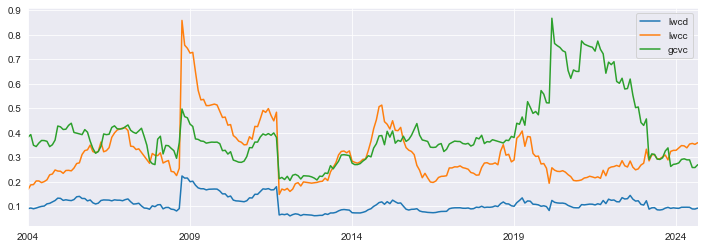

In [5]:
shrinkage = pd.DataFrame({k: pd.Series(v) for k, v in shrinkage_dict.items()}).T
fig, ax = plt.subplots(figsize=(12,4))
# shrinkage["bayes-stein"].plot(ax=ax, linestyle="--")
shrinkage[["lwcd", "lwcc", "gcvc"]].plot(ax=ax)
ax.legend()

In [13]:
eigenvalues = pd.concat({dt: pd.concat(
    {cov_type: pd.Series(np.linalg.eigvals(cov_dict[dt][cov_type].astype(np.float64))) 
     for cov_type in cov_dict[dt].keys()}, axis=1
) for dt in pfret.index}, axis=0)

In [13]:
def eval_plot(selected_date):
    eval_dt = eigenvalues.loc[pd.IndexSlice[selected_date,:],:].reset_index(0, drop=True)
    eval_dt.index = [str(e) for e in eval_dt.index]
    fig, ax = plt.subplots(figsize=(8,3))
    eval_dt.plot(ax=ax)
    ax.set_title(f"eigenvalues as of {selected_date}")
    display(shrinkage.loc[selected_date,:])

# Use SelectionSlider to allow specific date selection
date_slider = widgets.SelectionSlider(
    options=[ymd.strftime('%Y%m%d') for ymd in pfret.index],
    value=pfret.index[0].strftime('%Y%m%d'),  # Default selection to the first date
    description='Select Date',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Combine widgets into an interactive plot
interact(eval_plot, 
         selected_date=date_slider)

interactive(children=(SelectionSlider(description='Select Date', layout=Layout(width='500px'), options=('20040…

<function __main__.eval_plot(selected_date)>

## wgt

In [14]:
wgt_cls = wgt.groupby(axis=1, level=[0,3]).sum()

AssetClass
Cash            0.072644
Commodity       0.243310
Equity          0.465808
Fixed Income    0.218238
dtype: float64

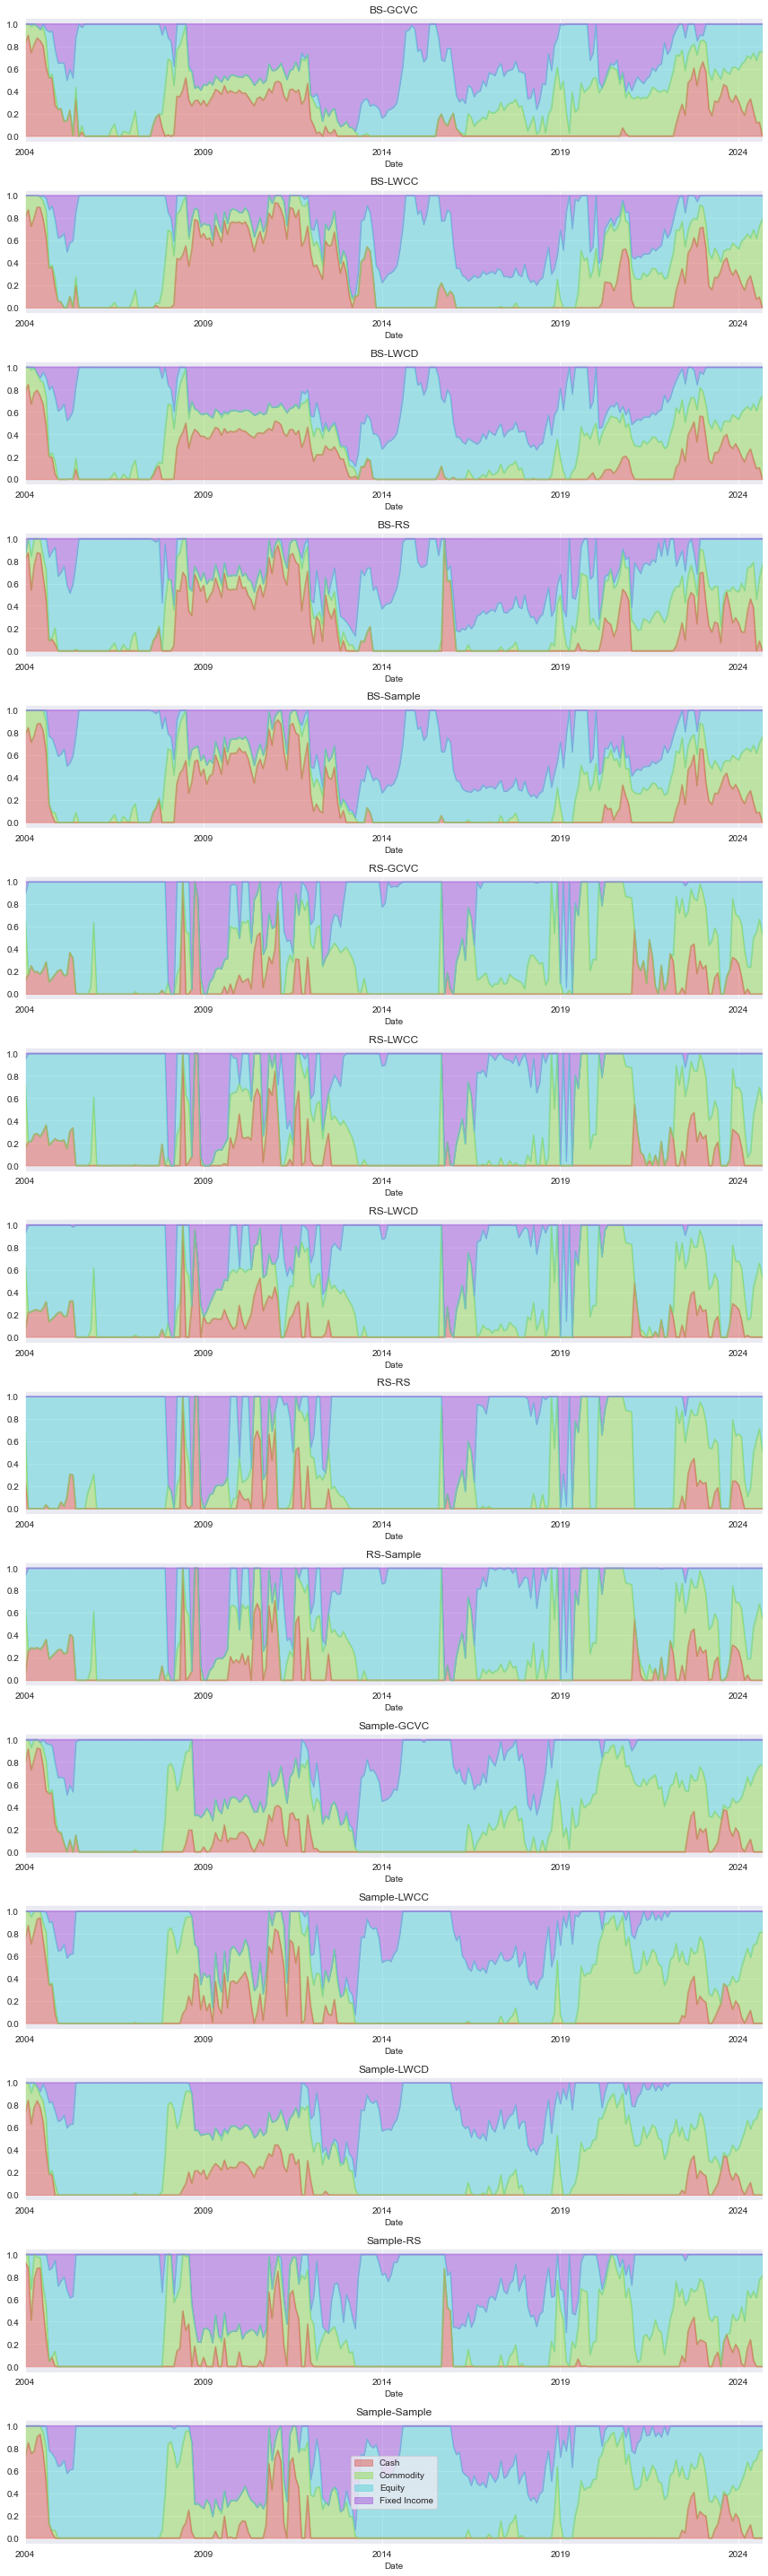

In [15]:
wgt_cls_ex_cash = wgt_cls.loc[:, pd.IndexSlice[:, ["Equity", "Fixed Income", "Commodity"]]]
wgt_cls_cash = wgt_cls.loc[:, pd.IndexSlice[:, "Cash"]]

strat_key = wgt_cls.columns.get_level_values(0).unique()
fig, ax = plt.subplots(len(strat_key), 1, figsize=(12,40), sharey=True)
for strat_i, strat in enumerate(strat_key):
#     wgt_cls_ex_cash[strat].clip(0).plot(kind="area", ax=ax[strat_i], alpha=.5)
#     ax_2y = ax[strat_i].twinx()
#     wgt_cls_cash[strat].plot(ax=ax_2y)
    col_list = sns.set_palette("hls", n_colors=len(wgt_cls[strat].columns))
    wgt_cls[strat].clip(0).plot(kind="area", ax=ax[strat_i], alpha=.5, color=col_list)
    ax[strat_i].set_title(strat)
    ax[strat_i].legend().remove() if strat_i+1 < len(strat_key) else ax[strat_i].legend()
fig.tight_layout()
display(wgt_cls[strat].mean())

In [16]:
wgt_cls.mean().unstack()

AssetClass         Cash  Commodity    Equity  Fixed Income
Strat                                                     
BS-GCVC        0.151910   0.196900  0.332719      0.318471
BS-LWCC        0.242622   0.141952  0.358801      0.256625
BS-LWCD        0.153827   0.168595  0.378546      0.299032
BS-RS          0.206830   0.143485  0.377748      0.271936
BS-Sample      0.185685   0.151400  0.359730      0.303184
RS-GCVC        0.077236   0.253133  0.529869      0.139761
RS-LWCC        0.091052   0.223915  0.542161      0.142872
RS-LWCD        0.078349   0.241061  0.552354      0.128237
RS-RS          0.054246   0.200137  0.612621      0.132996
RS-Sample      0.084420   0.238217  0.533157      0.144207
Sample-GCVC    0.074235   0.275994  0.458634      0.191138
Sample-LWCC    0.104296   0.233717  0.471315      0.190672
Sample-LWCD    0.081305   0.247706  0.486468      0.184522
Sample-RS      0.081258   0.220965  0.494911      0.202866
Sample-Sample  0.072644   0.243310  0.465808      0.218238

In [17]:
turnover_month = wgt.sub(wgt.shift(1)).abs().groupby(axis=1, level=[0]).sum() / 2
turnover_12m = turnover_month.groupby(pd.Grouper(freq="BY")).sum() / 2 

In [18]:
def show_turnover_plot(selected_strat, date_range, freq):
    col_list = sns.set_palette("hls", n_colors=len(selected_strat)) 
    fig, ax = plt.subplots(figsize=(12,5))
    start_date, end_date = date_range
    dat_to = turnover_month if freq=="month" else turnover_12m
    dat_to_select = dat_to.loc[start_date:end_date, selected_strat]
    dat_to_select.plot(ax=ax)
    ax.set_title("Rolling Vol")
    ax.legend(bbox_to_anchor=(1, 1))
    fig.show()
    display(dat_to_select.mean().sort_values(ascending=False))

turnover_freq = widgets.Dropdown(
    options=["month", "year"],
    value="month",
    description="Freq:"
)
    
# Create interactive widgets
strat_widget_turnover = widgets.SelectMultiple(
    options=option_strat,
    value=selection_strat,
    description='Strategy'
)

date_slider_turnover = widgets.SelectionRangeSlider(
    options=[ymd.strftime('%Y%m%d') for ymd in pfret.index],
    index=(SDATE_ADJ_IDX, len(pfret.index)-1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Combine widgets into an interactive plot
interact(show_turnover_plot, 
         selected_strat=strat_widget_turnover, 
         date_range=date_slider_turnover, 
         freq=turnover_freq)


interactive(children=(SelectMultiple(description='Strategy', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.show_turnover_plot(selected_strat, date_range, freq)>

## Estim Risk

In [19]:
wgt_cov_key_map = {
    "Sample": 'sample',
    "LWCD": 'lwcd',
    "LWCC": 'lwcc',
    "GCVC": 'gcvc',
    "RS": 'regime_switch'
}

In [20]:
# estimated vol
estim_risk = pd.DataFrame(index=wgt.index, columns=wgt.columns.get_level_values(0).unique())
for dt in tqdm(wgt.index):
    for cov_t in wgt.columns.get_level_values(0).unique():
        vcov = cov_dict[dt][wgt_cov_key_map[cov_t.split("-")[1]]] 
        ticker_order = vcov.columns.get_level_values("Ticker")
        w = wgt.loc[dt, pd.IndexSlice[cov_t,ticker_order,:,:,:]]
        estim_risk.loc[dt, cov_t] = (w.T @ vcov.values @ w * 52) ** .5

# historical vol        
VOL_LOOKBACK = 36
rolling_vol = (pfret.rolling(VOL_LOOKBACK).std() * np.sqrt(12)).dropna()

100%|██████████| 249/249 [00:13<00:00, 18.81it/s]


In [21]:
def show_vol_plot(selected_strat, date_range):
    col_list = sns.set_palette("hls", n_colors=len(selected_strat)) 
    fig, ax = plt.subplots(figsize=(12,5))
    start_date, end_date = date_range
    estim_risk_select = estim_risk.loc[start_date:end_date, selected_strat]
    rolling_vol_select = rolling_vol.loc[start_date:end_date, selected_strat]
    if len(selected_strat)>1:
        estim_risk_select.plot(ax=ax, color=col_list)
        rolling_vol_select.plot(ax=ax, color=col_list, linestyle="dashed")
        
    else: # col_list not work for 1-d data
        estim_risk_select.plot(ax=ax)
        rolling_vol_select.plot(ax=ax, linestyle="dashed")
    ax.set_title("Rolling Vol")
    ax.legend(bbox_to_anchor=(1, 1), ncol=2)
    fig.show()
    
    df_output = pd.concat([estim_risk_select, rolling_vol_select], 
                          axis=1, keys=["estim", "realised"]).mean().unstack()
    df_output.loc["estim/realised",:] = df_output.loc["estim",:].div(df_output.loc["realised",:])
    
    display(df_output)

# Create interactive widgets
strat_widget_vol = widgets.SelectMultiple(
    options=option_strat,
    value=selection_strat,
    description='Strategy'
)

date_slider_vol = widgets.SelectionRangeSlider(
    options=[ymd.strftime('%Y%m%d') for ymd in pfret.index],
    index=(SDATE_ADJ_IDX, len(pfret.index)-1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Combine widgets into an interactive plot
interact(show_vol_plot, 
         selected_strat=strat_widget_vol, 
         date_range=date_slider_vol)


interactive(children=(SelectMultiple(description='Strategy', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.show_vol_plot(selected_strat, date_range)>

## Instr Ret

In [103]:
instr_order = ["TPXDDVD Index", "SPXT Index", "SXXGR Index", "TUKXG Index", "0000AR Index", "AS51T Index", "M2EF Index",
               "GTJPY10Y Govt", "GT10 Govt", "GTDEM10Y Govt", "GUKG10 Index", "GTCAD10Y Govt", "GTAUD10Y Govt",
               "XAU Curncy", "JPYJPY", "USDJPY", "EURJPY", "GBPJPY", "CADJPY", "AUDJPY"]

In [109]:
summary_stats(ret_jpy.loc[FIG_SDATE:,pd.IndexSlice[:,instr_order,:,:]], freq="BM", styler=False).to_csv("output/tbl/instr_ret.csv")

In [107]:
ret_jpy.loc[FIG_SDATE:,pd.IndexSlice[:,instr_order,:,:]].corr().to_csv("output/tbl/instr_corr.csv")

In [100]:
ret_jpy

Name           S&P500  EURO STOXX    FTSE 100      S&P/TSX S&P/ASX 200  \
Ticker     SPXT Index SXXGR Index TUKXG Index 0000AR Index AS51T Index   
Currency          USD         EUR         GBP          CAD         AUD   
AssetClass     Equity      Equity      Equity       Equity      Equity   
2001-02-28  -0.084941   -0.079936   -0.062583    -0.146809   -0.039244   
2001-03-30   0.008232   -0.015951    0.006977    -0.018769   -0.054334   
2001-04-30   0.053311    0.055859    0.050986     0.060142    0.092696   
2001-05-31  -0.027946   -0.076828   -0.069784    -0.013920   -0.030004   
2001-06-29   0.020010    0.013959    0.016699     0.006107    0.096411   
...               ...         ...         ...          ...         ...   
2024-05-31   0.046326    0.049750    0.037932     0.035811    0.034025   
2024-06-28   0.059390   -0.001076    0.003987     0.003585    0.035615   
2024-07-31  -0.056405   -0.044735   -0.028015    -0.021486   -0.047245   
2024-08-30   0.027466    0.010153   -0.039576     0.020503   -0.008704   
2024-09-30   0.012328   -0.012778   -0.029465     0.021993    0.003232   

Name               TOPIX    MSCI EM  US 10y-bond Germany 10y-bond  \
Ticker     TPXDDVD Index M2EF Index    GT10 Govt    GTDEM10Y Govt   
Currency             JPY        USD          USD              EUR   
AssetClass        Equity     Equity Fixed Income     Fixed Income   
2001-02-28     -0.045000  -0.071970     0.014213        -0.003242   
2001-03-30      0.033052  -0.029305     0.074595         0.025237   
2001-04-30      0.069836   0.025651    -0.053717        -0.034097   
2001-05-31     -0.040676  -0.022889    -0.037315        -0.089485   
2001-06-29     -0.007150   0.023989     0.043263         0.056463   
...                  ...        ...          ...              ...   
2024-05-31      0.011571   0.002819     0.011250         0.007573   
2024-06-28      0.014524   0.063681     0.031080         0.024923   
2024-07-31     -0.005407  -0.064326    -0.040438        -0.039817   
2024-08-30     -0.028964   0.019664     0.013065        -0.005160   
2024-09-30     -0.015315   0.057763     0.001071         0.005357   

Name        UK 10y-bond Canada 10y-bond Australia 10y-bond Japan 10y-bond  \
Ticker     GUKG10 Index   GTCAD10Y Govt      GTAUD10Y Govt  GTJPY10Y Govt   
Currency            GBP             CAD                AUD            JPY   
AssetClass Fixed Income    Fixed Income       Fixed Income   Fixed Income   
2001-02-28    -0.009404       -0.012197          -0.031379        -0.0173   
2001-03-30     0.053177        0.034567          -0.006842        -0.0007   
2001-04-30    -0.033990       -0.010074          -0.009100        -0.0053   
2001-05-31    -0.052129       -0.012681          -0.061709         0.0099   
2001-06-29     0.034402        0.053153           0.055252         0.0220   
...                 ...             ...                ...            ...   
2024-05-31     0.018967        0.024523           0.026271        -0.0169   
2024-06-28     0.026056        0.029309           0.033734         0.0013   
2024-07-31    -0.037403       -0.048508          -0.070768         0.0018   
2024-08-30    -0.049721        0.008395          -0.001185         0.0142   
2024-09-30    -0.013509        0.007800          -0.025971         0.0032   

Name             GOLD    AUDJPY    CADJPY    EURJPY    GBPJPY    JPYJPY  \
Ticker     XAU Curncy    AUDJPY    CADJPY    EURJPY    GBPJPY    JPYJPY   
Currency          USD       AUD       CAD       EUR       GBP       JPY   
AssetClass  Commodity      Cash      Cash      Cash      Cash      Cash   
2001-02-28   0.011786 -0.033059 -0.011820 -0.002389 -0.000809  0.000207   
2001-03-30   0.039356 -0.002062  0.044052  0.025808  0.057906  0.000090   
2001-04-30   0.000475  0.036617  0.018602 -0.005918 -0.005059  0.000017   
2001-05-31  -0.027836 -0.041797 -0.037296 -0.077619 -0.039954  0.000015   
2001-06-29   0.065121  0.060816  0.062948  0.054729  0.047728  0.000015   
...               ... 

In [68]:
ret_jpy_ann = ret_jpy.groupby(pd.Grouper(freq="BY")).apply(lambda x: (1+x).prod()-1)
ret_jpy_ann.index = [r.strftime("%Y") for r in ret_jpy_ann.index]
ret_jpy_ann.columns = ret_jpy_ann.columns.get_level_values(1)

def show_instr_ret_ann(selected_instr):
    fig, ax = plt.subplots(figsize=(15,4))
    ret_jpy_ann.loc[:,selected_instr].plot(kind="bar", ax=ax)
    ax.legend(loc="lower right", bbox_to_anchor=(1.3,0), ncol=2)
    plt.show()
    
option_instr = ret_jpy.columns.get_level_values(1).unique()
selection_strat = list(option_instr)
    
strat_widget_instr_ret = widgets.SelectMultiple(
    options=option_instr,
    value=selection_strat,
    description='Strategy'
)

interact(show_instr_ret_ann, 
         selected_instr=strat_widget_instr_ret)


interactive(children=(SelectMultiple(description='Strategy', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.show_instr_ret_ann(selected_instr)>

## FIGS / TABLES

In [7]:
FIG_SDATE_PREV = "2007-09-28"
FIG_SDATE = "2007-10-31"
FIG_EDATE = "2024-09-30"

### performance

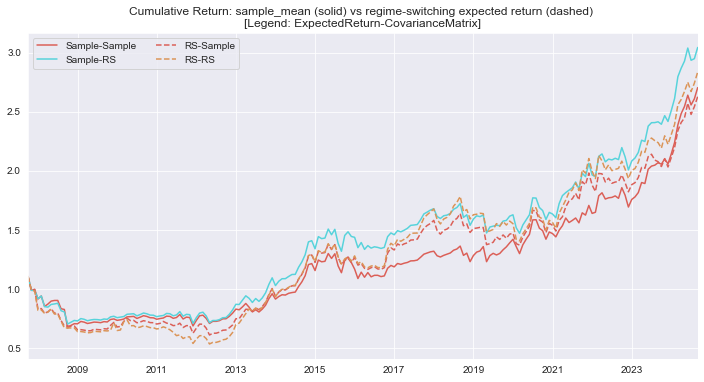

In [27]:
# cols_solid = ['Sample-Sample', 'Sample-LWCD', 'Sample-LWCC', 'Sample-GCVC']
# cols_dashed = ['BS-Sample', 'BS-LWCD', 'BS-LWCC', 'BS-GCVC']
# fig_title = "Cumulative Return: sample_mean (solid) vs Bayes-Stein expected return (dashed) \n[Legend: ExpectedReturn-CovarianceMatrix]"
# output_name = "PerfShrinkage_LO"

cols_solid = ['Sample-Sample', 'Sample-RS']
cols_dashed = ['RS-Sample', 'RS-RS']
fig_title = "Cumulative Return: sample_mean (solid) vs regime-switching expected return (dashed) \n[Legend: ExpectedReturn-CovarianceMatrix]"
output_name = "PerfRegimeSwitch_LO"

fig, ax = plt.subplots(figsize=(12,6))

# solid line
colours_solid = sns.color_palette("hls", n_colors=len(cols_solid))
(1+pfret.loc[FIG_SDATE:FIG_EDATE,cols_solid]).cumprod().plot(ax=ax, color=colours_solid)

# dashed line
colours_dashed = sns.color_palette(n_colors=len(cols_dashed))
(1+pfret.loc[FIG_SDATE:FIG_EDATE,cols_dashed]).cumprod().plot(ax=ax, color=colours_dashed, linestyle="--")

ax.set_title(fig_title)
ax.legend(ncol=2)
plt.savefig(f"output/fig/{output_name}.png")
summary_stats(pfret.loc[FIG_SDATE:FIG_EDATE,cols_solid+cols_dashed], freq="BM", styler=False).to_csv(f"output/tbl/{output_name}.csv")

summary_stats(pfret.loc[FIG_SDATE:FIG_EDATE,cols_solid+cols_dashed], freq="BM")

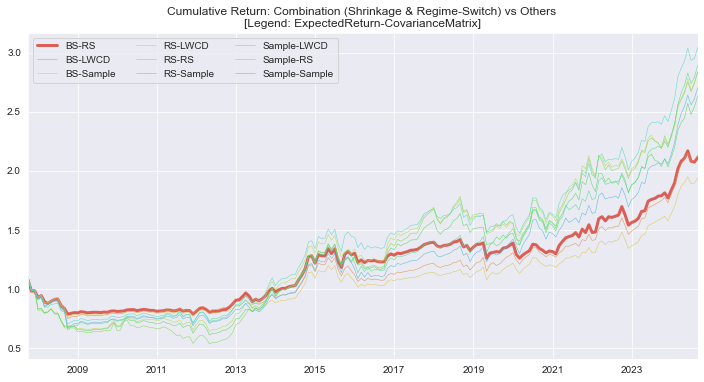

In [28]:
cols_thick = ['BS-RS']
cols_thin = ['BS-LWCD', 'BS-Sample', 
             'RS-LWCD', 'RS-RS', 'RS-Sample', 
             'Sample-LWCD', 'Sample-RS', 'Sample-Sample']
fig_title = "Cumulative Return: Combination (Shrinkage & Regime-Switch) vs Others \n[Legend: ExpectedReturn-CovarianceMatrix]"
output_name = "PerfRegimeCombs_LO"

fig, ax = plt.subplots(figsize=(12,6))

# thick line
(1+pfret.loc[FIG_SDATE:FIG_EDATE,cols_thick]).cumprod().plot(ax=ax, linewidth=3)

# thin line
(1+pfret.loc[FIG_SDATE:FIG_EDATE,cols_thin]).cumprod().plot(ax=ax, linewidth=.5)

ax.set_title(fig_title)
ax.legend(ncol=3)
plt.savefig(f"output/fig/{output_name}.png")
summary_stats(pfret.loc[FIG_SDATE:FIG_EDATE,cols_thick+cols_thin], freq="BM", styler=False).to_csv(f"output/tbl/{output_name}.csv")

summary_stats(pfret.loc[FIG_SDATE:FIG_EDATE,cols_thick+cols_thin], freq="BM")

### Shrinkage intensity

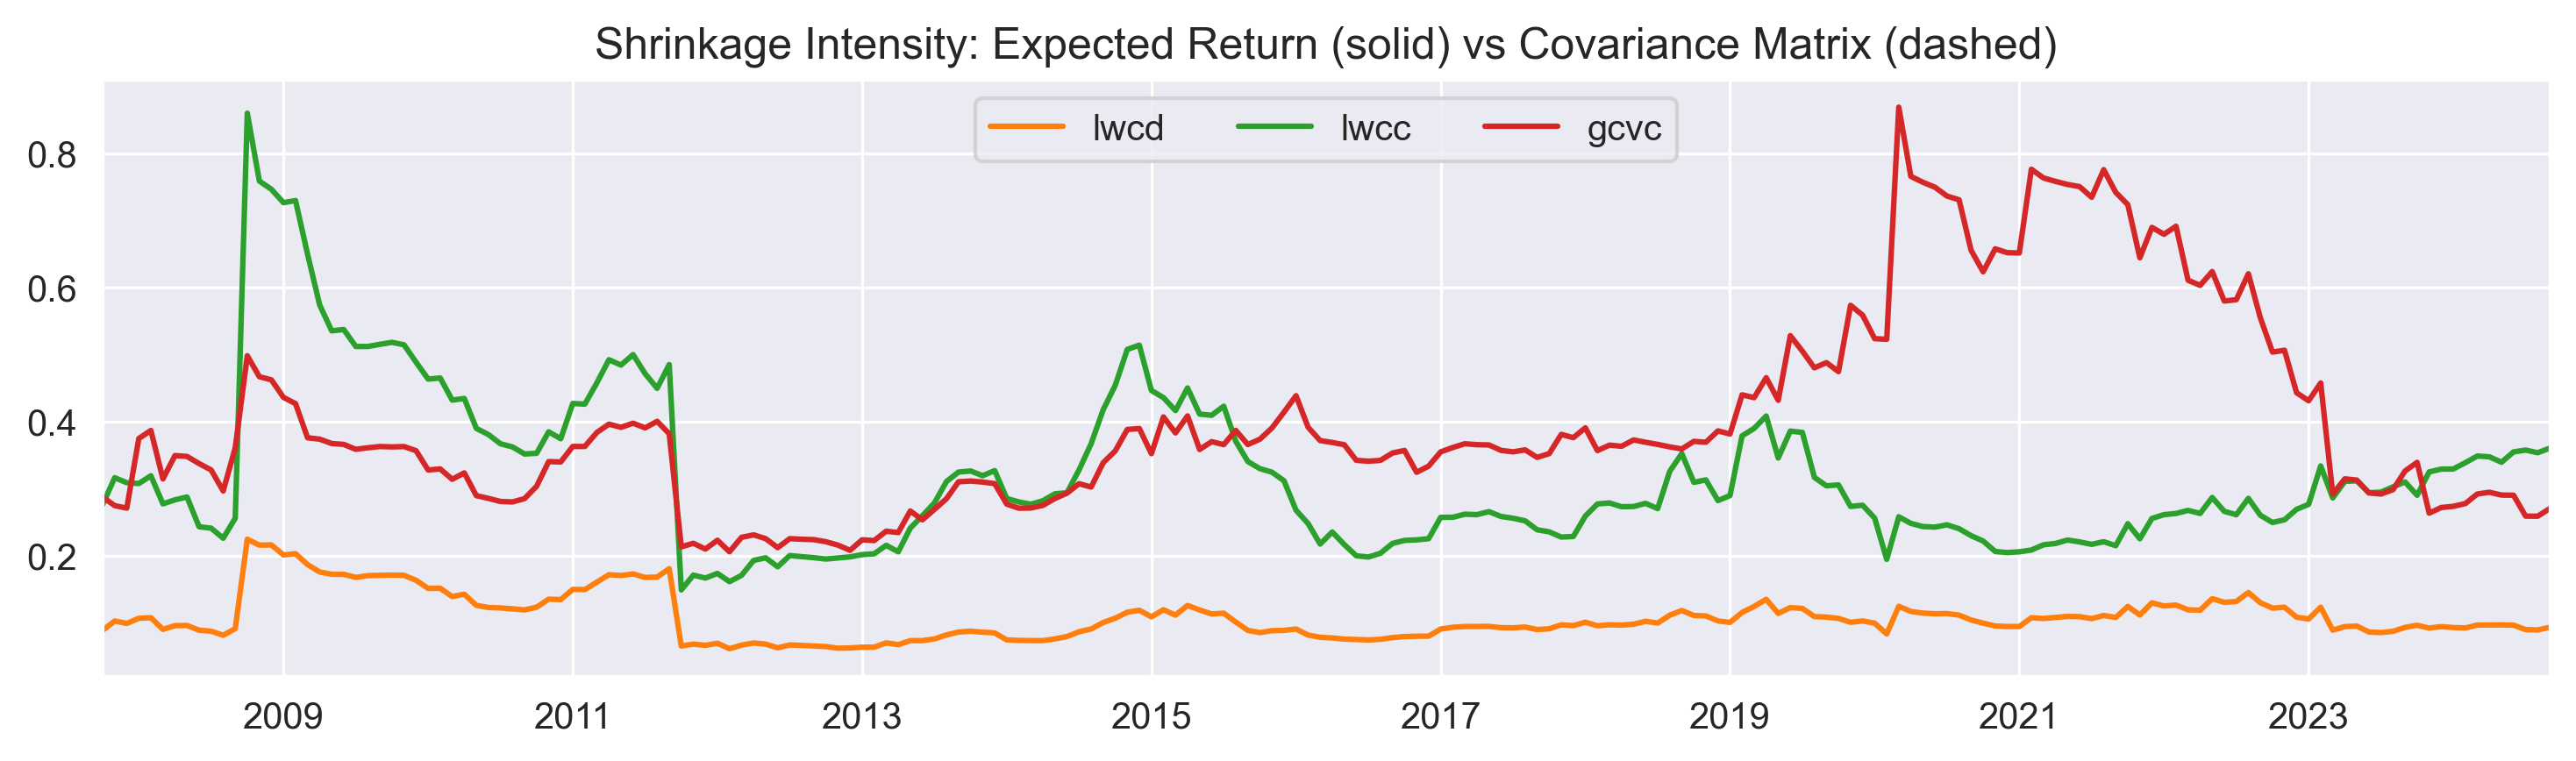

In [12]:
cols_solid = ["bayes-stein"]
cols_dashed = ["lwcd", "lwcc", "gcvc"]
fig_title = "Shrinkage Intensity: Expected Return (solid) vs Covariance Matrix (dashed)"
output_name = "ShrinkageIntensity_LO"

fig, ax = plt.subplots(figsize=(12,3), dpi=300)

# solid line
colours = sns.color_palette(n_colors=len(cols_solid+cols_dashed))
# colours_solid = colours[0]
# shrinkage.loc[FIG_SDATE:FIG_EDATE,cols_solid].plot(ax=ax, color=colours_solid)

# dashed line
colours_dashed = colours[1:]
shrinkage.loc[FIG_SDATE:FIG_EDATE,cols_dashed].plot(ax=ax, color=colours_dashed, linestyle="-")

ax.set_title(fig_title)
ax.legend(ncol=3)
plt.savefig(f"output/fig/{output_name}.png")
# shrinkage.to_csv(f"output/tbl/{output_name}.csv")

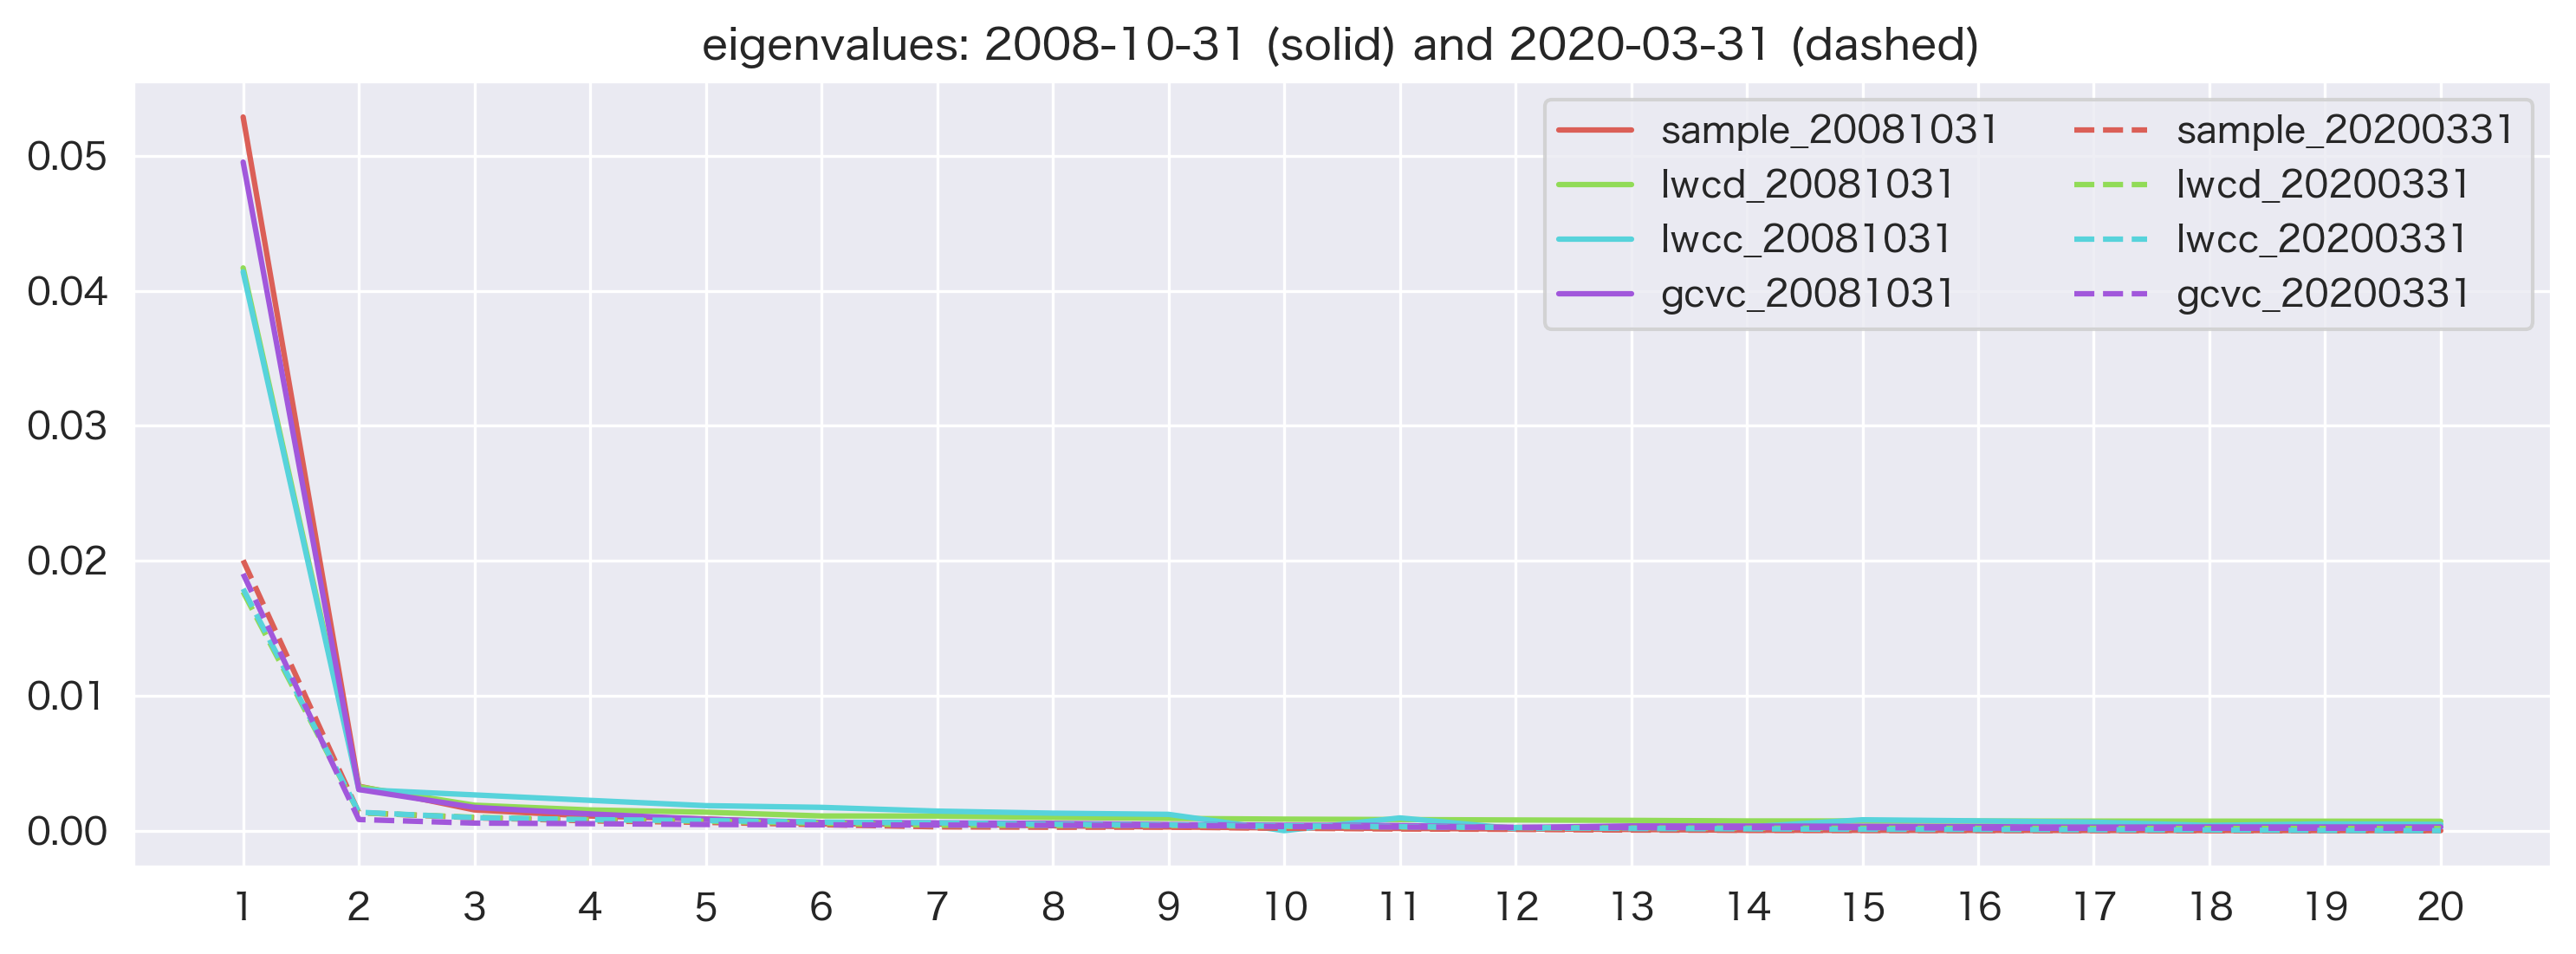

In [25]:
eig_date_1 = "2008-10-31"
eig_date_2 = "2020-03-31"

fig_title = f"eigenvalues: {eig_date_1} (solid) and {eig_date_2} (dashed)"
output_name = "eigenvalues_shrinkage_LO"

eig_cols = ["sample", "lwcd", "lwcc", "gcvc"]

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
colours = sns.color_palette("hls", n_colors=len(eig_cols))
fig_eigs_1 = eigenvalues.loc[pd.IndexSlice[eig_date_1,:],eig_cols].reset_index(0, drop=True)
fig_eigs_1.columns = [f"{c}_{eig_date_1.replace('-', '')}" for c in fig_eigs_1.columns]
fig_eigs_1.plot(ax=ax, color=colours)

fig_eigs_2 = eigenvalues.loc[pd.IndexSlice[eig_date_2,:],eig_cols].reset_index(0, drop=True)
fig_eigs_2.columns = [f"{c}_{eig_date_2.replace('-', '')}" for c in fig_eigs_2.columns]
fig_eigs_2.plot(ax=ax, color=colours, linestyle="--")

x_ticks = range(len(fig_eigs_1)) 
ax.set_xticks(x_ticks)
ax.set_xticklabels([x+1 for x in x_ticks])

ax.set_title(fig_title)
ax.legend(ncol=2)
plt.savefig(f"output/fig/{output_name}.png")

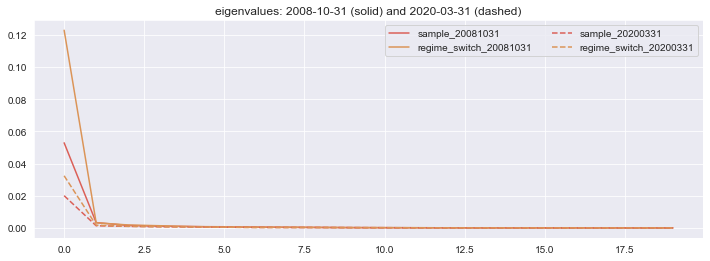

In [44]:
eig_date_1 = "2008-10-31"
eig_date_2 = "2020-03-31"

fig_title = f"eigenvalues: {eig_date_1} (solid) and {eig_date_2} (dashed)"
output_name = "eigenvalues_regime-switch_LO"

eig_cols = ["sample", "regime_switch"]

fig, ax = plt.subplots(figsize=(12,4))
colours = sns.color_palette(n_colors=len(eig_cols))
fig_eigs_1 = eigenvalues.loc[pd.IndexSlice[eig_date_1,:],eig_cols].reset_index(0, drop=True)
fig_eigs_1.columns = [f"{c}_{eig_date_1.replace('-', '')}" for c in fig_eigs_1.columns]
fig_eigs_1.plot(ax=ax, color=colours)

fig_eigs_2 = eigenvalues.loc[pd.IndexSlice[eig_date_2,:],eig_cols].reset_index(0, drop=True)
fig_eigs_2.columns = [f"{c}_{eig_date_2.replace('-', '')}" for c in fig_eigs_2.columns]
fig_eigs_2.plot(ax=ax, color=colours, linestyle="--")

ax.set_title(fig_title)
ax.legend(ncol=2)
plt.savefig(f"output/fig/{output_name}.png")

### Regimes

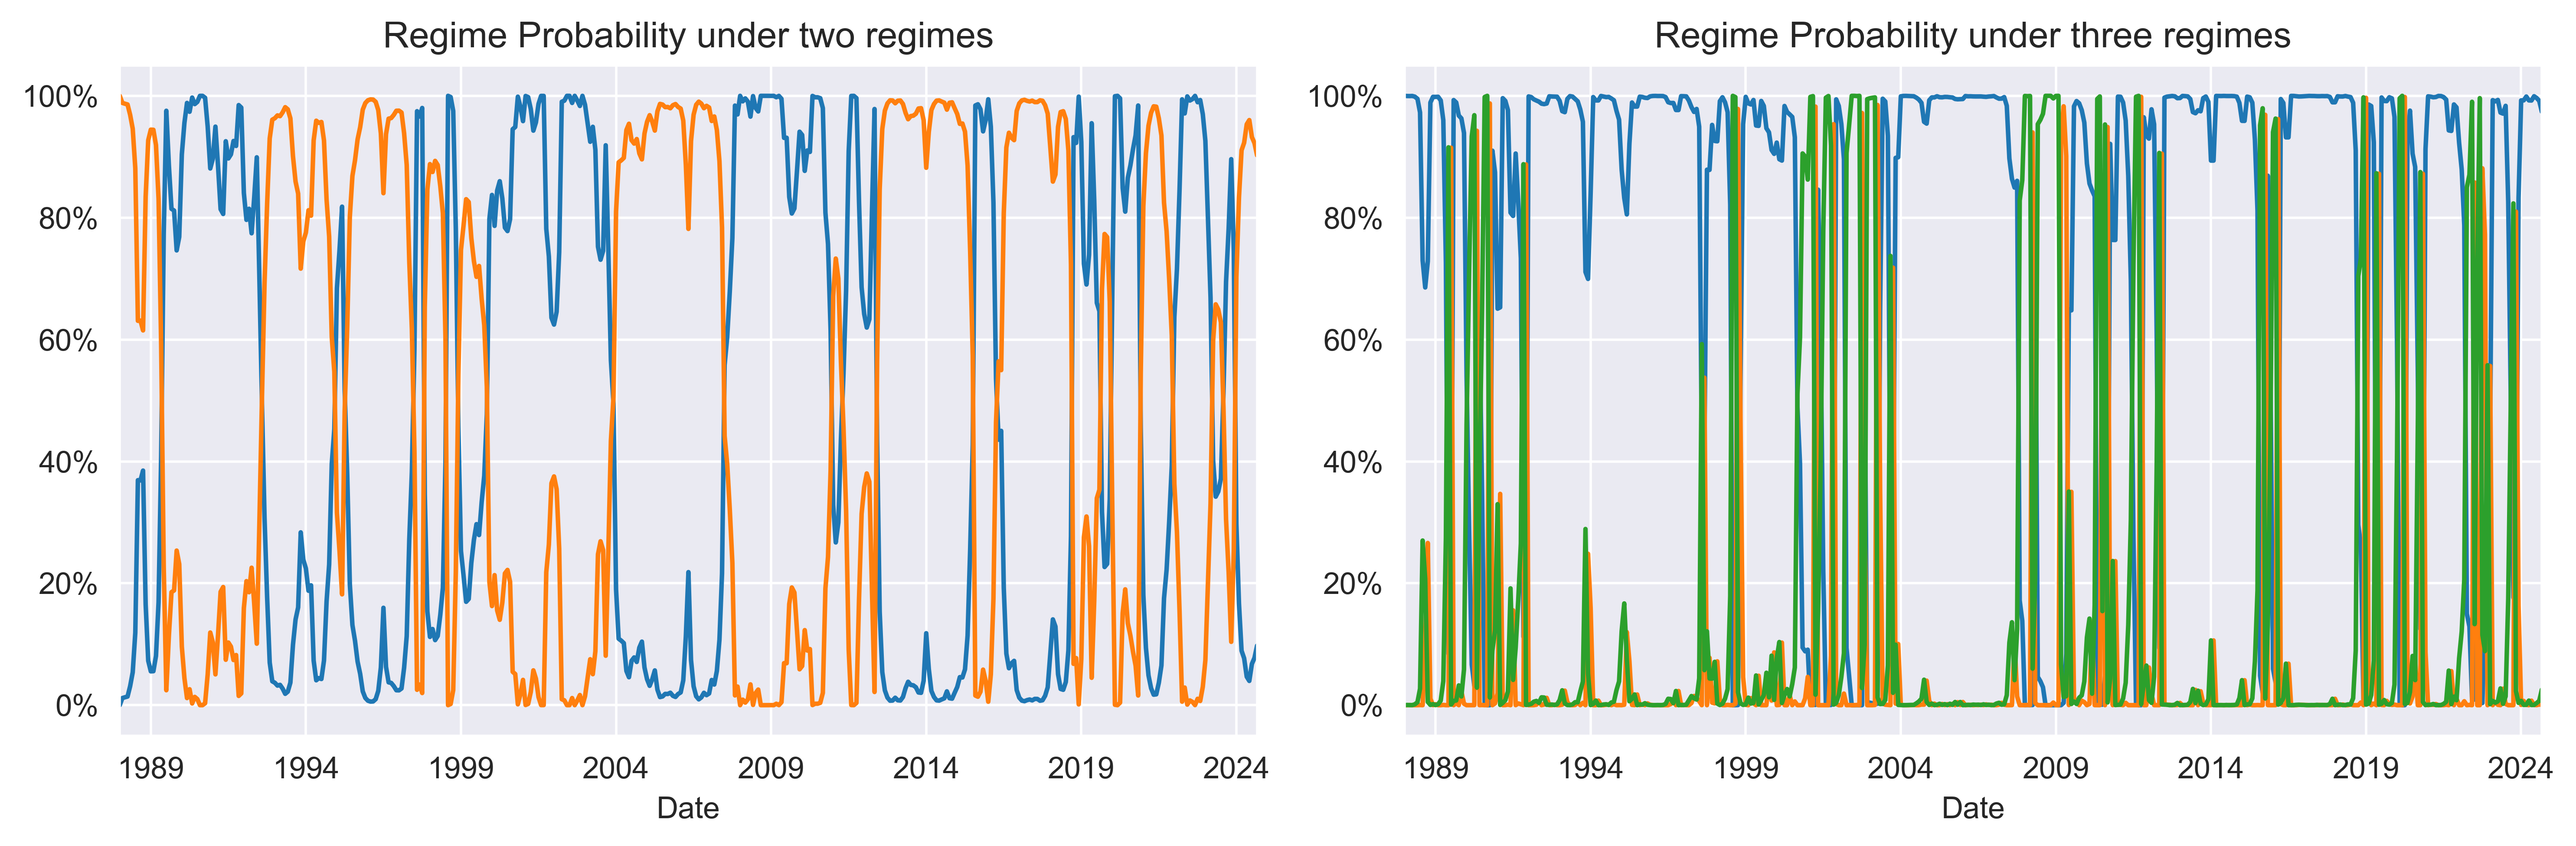

In [29]:
output_name = "estimated_regimes"

hmm_eqfi_2 = regime_dict["EQ-FI"][0]
hmm_eqfi_3 = regime_dict["EQ-FI"][1]

fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=500)
hmm_eqfi_2.plot(ax=ax[0])
ax[0].set_title("Regime Probability under two regimes")
ax[0].yaxis.set_major_formatter(PercentFormatter(1))
ax[0].legend().remove()
hmm_eqfi_3.plot(ax=ax[1])
ax[1].set_title("Regime Probability under three regimes")
ax[1].yaxis.set_major_formatter(PercentFormatter(1))
ax[1].legend().remove()
fig.tight_layout()
plt.savefig(f"output/fig/{output_name}.png")

In [35]:
idx_dat.dropna()

SBWGU Index  MXWD Index
Date                               
1987-12-31     185.3879      100.00
1988-01-29     184.3822      102.33
1988-02-29     185.9868      108.07
1988-03-31     189.3149      111.22
1988-04-29     188.3924      112.45
...                 ...         ...
2024-05-31     844.1167      785.54
2024-06-28     843.8272      802.01
2024-07-31     867.9562      814.16
2024-08-30     887.9359      833.68
2024-09-30     902.5141      851.78

[442 rows x 2 columns]

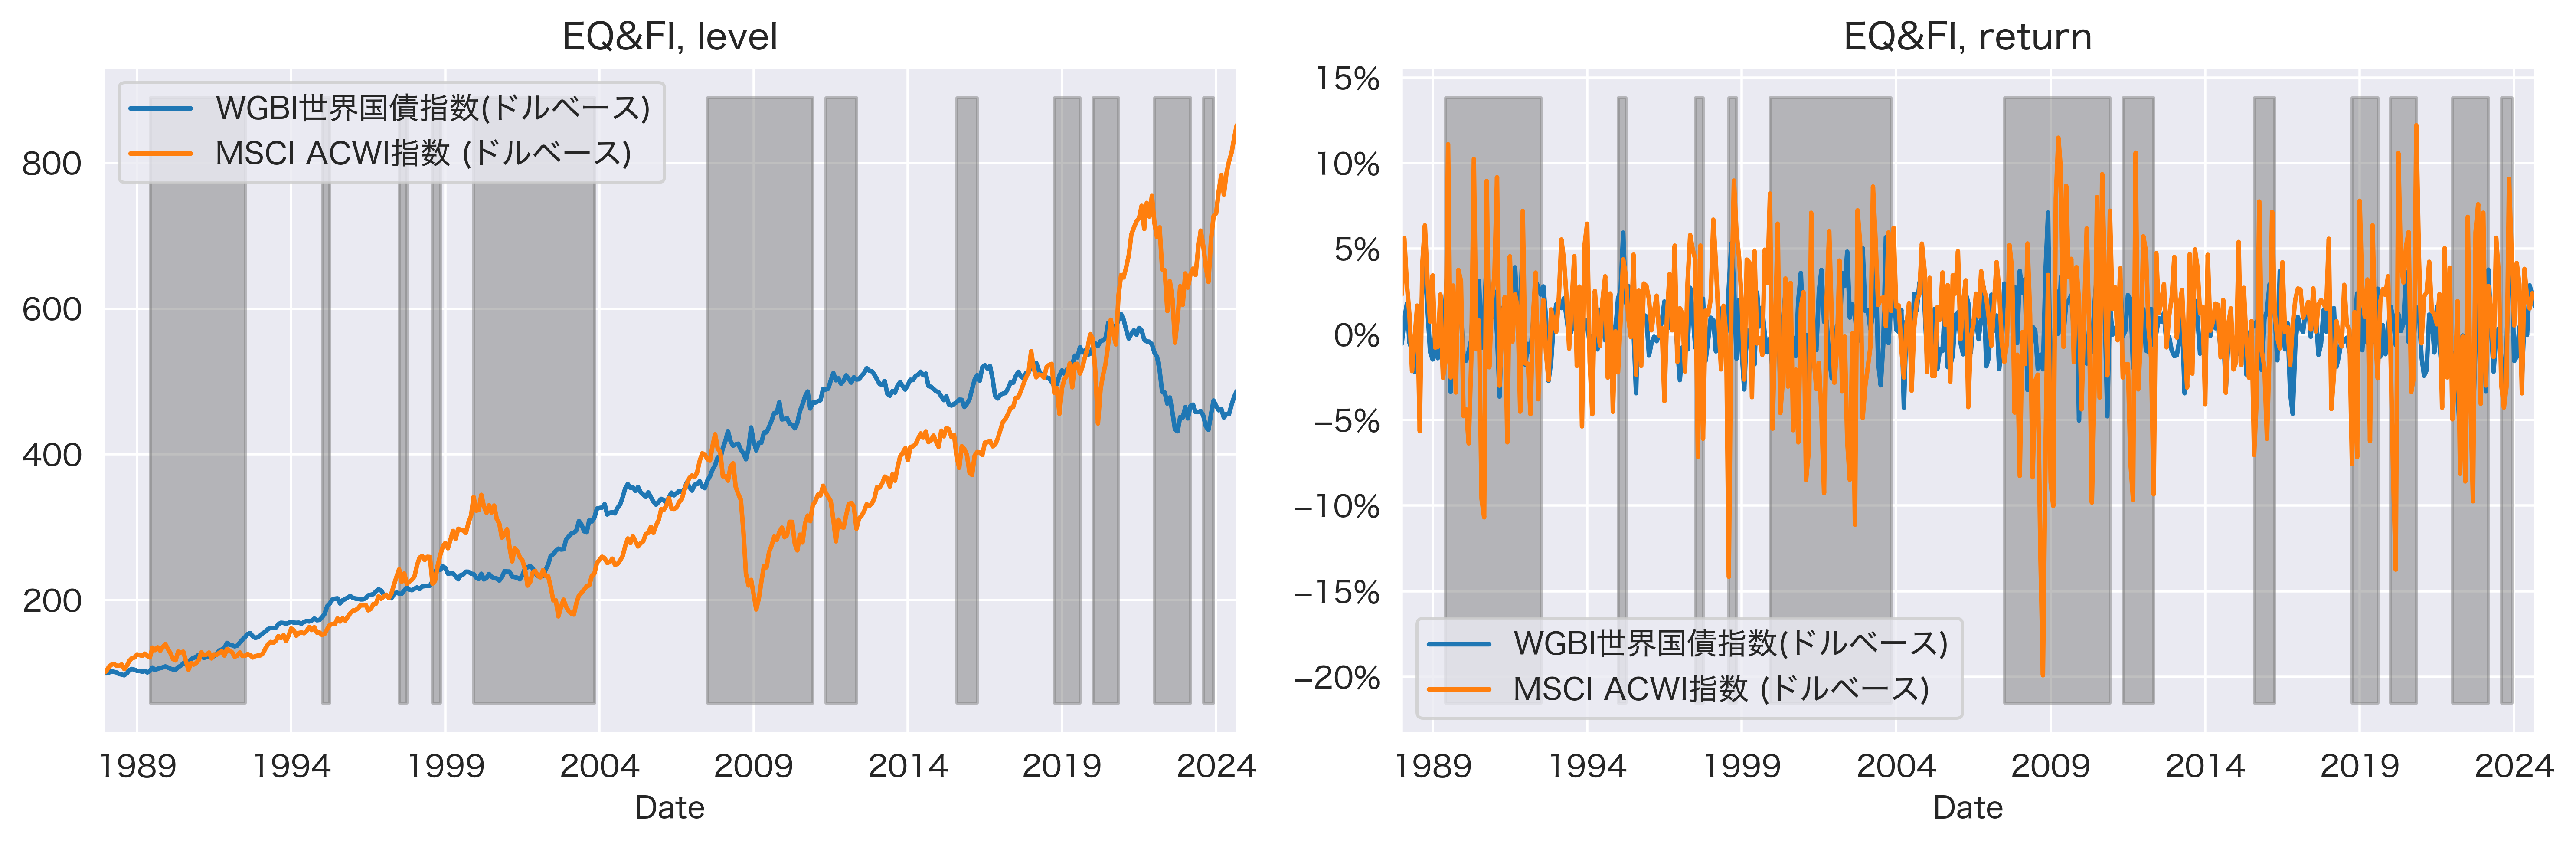

In [39]:
from matplotlib import rcParams
from matplotlib import font_manager

# for font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
#     print(font)

idx_dat_1990_std = idx_dat.div(idx_dat.loc["1987/12",:].values/100).loc["1987/12":,:]

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc"  # 適切なフォントファイルのパス
font_prop = font_manager.FontProperties(fname=font_path)
rcParams['font.family'] = font_prop.get_name()

output_name = "factor_return_with_regimes"

col_map = {"SBWGU Index": "WGBI世界国債指数(ドルベース)", "MXWD Index": "MSCI ACWI指数 (ドルベース)"}

fig_config = {
    "EQ&FI, level": [idx_dat_1990_std, hmm_eqfi_2, 0],
    "EQ&FI, return": [idx_ret, hmm_eqfi_2, 0],
}

fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=500)
for fig_i, (fig_k, fig_v) in enumerate(fig_config.items()):
    fig_v[0].rename(columns=col_map).plot(ax=ax[fig_i])
    ax[fig_i].fill_between(fig_v[1].index, ax[fig_i].get_ylim()[0], ax[fig_i].get_ylim()[1], where=(fig_v[1].iloc[:,fig_v[2]]>0.5), color="gray", alpha=0.5, step="mid")
    ax[fig_i].set_title(fig_k)

ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
fig.tight_layout()
plt.savefig(f"output/fig/{output_name}.png")

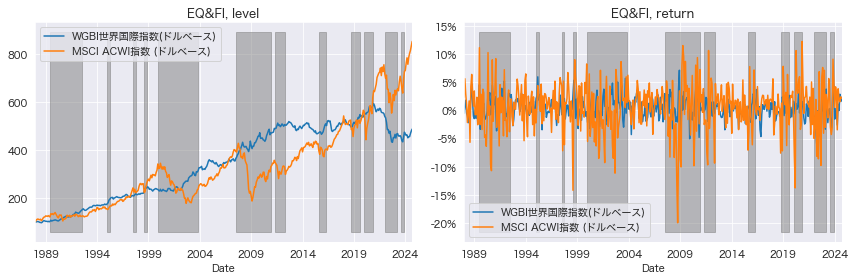

In [38]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
from matplotlib.ticker import FuncFormatter

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc"  
font_prop = font_manager.FontProperties(fname=font_path)
rcParams['font.family'] = font_prop.get_name()


col_map = {"SBWGU Index": "WGBI世界国際指数(ドルベース)", "MXWD Index": "MSCI ACWI指数 (ドルベース)"}

fig_config = {
    "EQ&FI, level": [idx_dat_1990_std, hmm_eqfi_2, 0],
    "EQ&FI, return": [idx_ret, hmm_eqfi_2, 0],
}

output_name = "factor_return_with_regimes"

# %表示フォーマッターを定義
def percent_formatter(x, pos):
    return f"{x * 100:.0f}%"

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for fig_i, (fig_k, fig_v) in enumerate(fig_config.items()):
    fig_v[0].rename(columns=col_map).plot(ax=ax[fig_i])
    ax[fig_i].fill_between(
        fig_v[1].index,
        ax[fig_i].get_ylim()[0],
        ax[fig_i].get_ylim()[1],
        where=(fig_v[1].iloc[:, fig_v[2]] > 0.5),
        color="gray",
        alpha=0.5,
        step="mid"
    )
    ax[fig_i].set_title(fig_k)
    
    # ax[1]に対してx軸を％表示に設定
    if fig_i == 1:
        ax[fig_i].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

fig.tight_layout()
plt.savefig(f"output/fig/{output_name}.png")


In [10]:
fig_v[0]

SBWGU Index  MXWD Index
Date                               
1988-01-29    -0.005425    0.023300
1988-02-29     0.008703    0.056093
1988-03-31     0.017894    0.029148
1988-04-29    -0.004873    0.011059
1988-05-31    -0.009386   -0.021432
...                 ...         ...
2024-05-31     0.010756    0.038236
2024-06-28    -0.000343    0.020966
2024-07-31     0.028595    0.015149
2024-08-30     0.023019    0.023976
2024-09-30     0.016418    0.021711

[441 rows x 2 columns]

In [ ]:
### botsu

In [ ]:
fig_title = "Cumulative Return: Shrinkage_RegimeSwitch (Thick line) vs Others (Thin line)"
ENDDATE = "2024/9/30"

comp_strat = ["ledoit_wolf", "regime_switch"]
comp_mean = ["bayes-stein", "regime_switch", "sample"]
comp_cov = ["LW_common_diag", "regime_switch", "sample"]

fig, ax = plt.subplots(figsize=(12,6))
fig_ret = ret_all.loc[:ENDDATE,pd.IndexSlice["shrinkage_rs","idx_jpy","All",:,:]]
# col_list = sns.color_palette(n_colors=fig_ret.shape[1])
fig_ret.columns = pd.MultiIndex.from_arrays([fig_ret.columns.get_level_values(3),fig_ret.columns.get_level_values(4)])
(1+fig_ret).cumprod().plot(ax=ax, linewidth=2)
fig_ret_2 = ret_all.loc[:ENDDATE,pd.IndexSlice[comp_strat,"idx_jpy","All",comp_mean,comp_cov]]
fig_ret_2.columns = pd.MultiIndex.from_arrays([fig_ret_2.columns.get_level_values(3),fig_ret_2.columns.get_level_values(4)])
(1+fig_ret_2).cumprod().plot(ax=ax, linewidth=.5)
ax.set_title(fig_title)
ax.legend(ncol=2)
display(summary_stats(pd.concat([fig_ret, fig_ret_2], axis=1).dropna(), freq="BM"))

In [ ]:
ENDDATE = "2024/9/30"
fig, ax = plt.subplots(figsize=(12,6))
fig_lw_shrinkage = lw_shrinkage.loc[:ENDDATE,pd.IndexSlice["idx","All",:]]
fig_lw_shrinkage.columns = fig_lw_shrinkage.columns.get_level_values(2)
col_list = sns.color_palette(n_colors=4)
fig_lw_shrinkage.plot(ax=ax, color=col_list[:-1])

fig_bs_shrinkage = bs_shrinkage.loc[:ENDDATE,pd.IndexSlice["idx","All"]]
fig_bs_shrinkage.columns = ["Bayes-Stein"]
fig_bs_shrinkage.name = "Bayes-Stein"
fig_bs_shrinkage.plot(ax=ax, color=col_list[-1], linestyle="--")
ax.set_title("Shrinkage Intensity: Expected Return (dashed) and Covariance Matrix (solid)")
ax.legend(ncol=2)

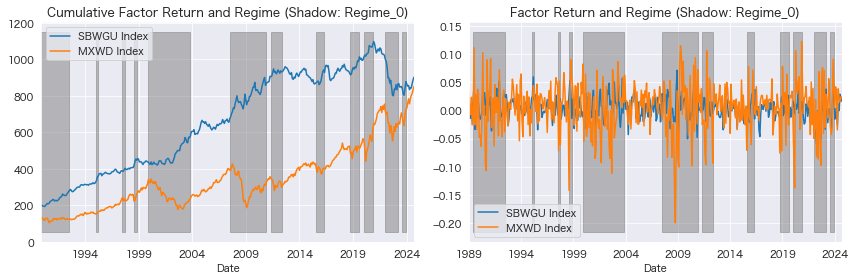

In [30]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
idx_dat.loc["1989/12":,:].plot(ax=ax[0])
ax[0].fill_between(hmm_eqfi_2.index, ax[0].get_ylim()[0], ax[0].get_ylim()[1], where=(hmm_eqfi_2.iloc[:,0]>0.5), color="gray", alpha=0.5, step="mid")
ax[0].set_title("Cumulative Factor Return and Regime (Shadow: Regime_0)")
idx_ret.loc["1989":,:].plot(ax=ax[1])
ax[1].fill_between(hmm_eqfi_2.index, ax[1].get_ylim()[0], ax[1].get_ylim()[1], where=(hmm_eqfi_2.iloc[:,0]>0.5), color="gray", alpha=0.5, step="mid")
ax[1].set_title("Factor Return and Regime (Shadow: Regime_0)")
fig.tight_layout()